# Visualization

Little notebook that allow to explore the result of the model

In [20]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Fix paths so we can import from src
sys.path.append(os.path.abspath('..'))

from src.model_pytorch import BioVAE
from main import get_loaders, CONFIG

# 2. Setup
DEVICE = CONFIG["DEVICE"]
CHECKPOINT_PATH = os.path.join("..", CONFIG["SAVE_DIR"], "biovae_bloodmnist.pth")

print(f"Loading model from {CHECKPOINT_PATH}...")

def get_latent_features(loader):
    vectors = []
    labels = []
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(DEVICE)
            # Encode image -> Latent Vector
            mu = model.fc_mu(model.encoder(data))
            vectors.append(mu.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(vectors), np.concatenate(labels).squeeze()

Loading model from ..\checkpoints\biovae_bloodmnist.pth...


In [16]:
# 3. Load model and get the data
model = BioVAE().to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()

_, test_loader = get_loaders(CONFIG["DATA_FLAG"], batch_size=500)

In [17]:
# 5. Extract Latent Vectors
# We want to see how the model 'thinks' about different cells.
latent_vectors = []
labels = []

print("Extracting features...")
with torch.no_grad():
    for data, targets in tqdm(test_loader):
        data = data.to(DEVICE)
        
        # We only need the Encoder part: Image -> Latent Vector (mu)
        x_encoded = model.encoder(data)
        mu = model.fc_mu(x_encoded)
        
        latent_vectors.append(mu.cpu().numpy())
        labels.append(targets.numpy())

# Concatenate all batches
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0).squeeze()

print(f"Extracted {latent_vectors.shape[0]} cell signatures.")

Extracting features...


100%|██████████| 7/7 [00:00<00:00, 24.69it/s]

Extracted 3421 cell signatures.


Running t-SNE (this might take a moment)...


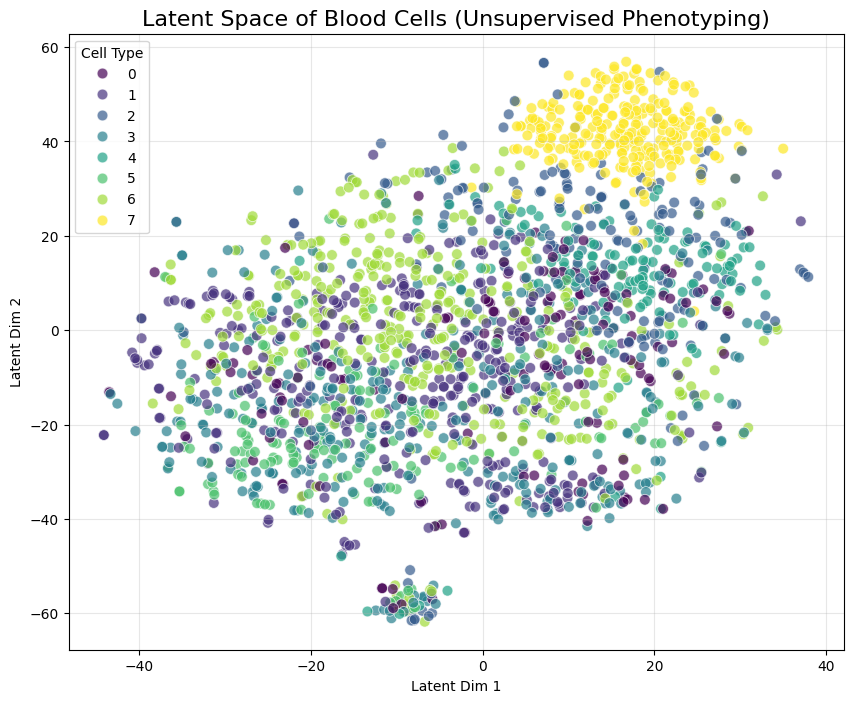

In [19]:
# 6. Dimensionality Reduction (20D -> 2D)
# We use t-SNE to squash the 20 latent dimensions into 2D so we can see them.
print("Running t-SNE (this might take a moment)...")
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors[:2000]) # Use first 2000 points for speed
labels_subset = labels[:2000]

# 7. Plotting the "Phenotype Map"
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=latent_2d[:, 0], 
    y=latent_2d[:, 1], 
    hue=labels_subset, 
    palette="viridis", 
    s=60, 
    alpha=0.7,
    legend="full"
)

plt.title("Latent Space of Blood Cells (Unsupervised Phenotyping)", fontsize=16)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.legend(title="Cell Type")
plt.grid(True, alpha=0.3)


plt.savefig("../latent_space.png", dpi=300)

In [5]:
# Get loaders again (full batches)
train_loader, test_loader = get_loaders(CONFIG["DATA_FLAG"], batch_size=256)

X_train, y_train = get_latent_features(train_loader)
X_test, y_test = get_latent_features(test_loader)

# 2. Train a Simple Linear Classifier
# We are NOT training the Deep Learning model here. 
# We are just checking if the VAE's "Latent Space" is useful.
# Change solver from 'liblinear' to 'lbfgs' (or 'saga')
clf = LogisticRegression(max_iter=3000, solver='lbfgs')
clf.fit(X_train, y_train)

# 3. Predict and Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nLatent Space Classification Accuracy: {acc*100:.2f}%")
print("-" * 30)
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))


Latent Space Classification Accuracy: 69.07%
------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.56       244
           1       0.77      0.71      0.74       624
           2       0.69      0.56      0.62       311
           3       0.47      0.58      0.52       579
           4       0.73      0.73      0.73       243
           5       0.52      0.35      0.42       284
           6       0.74      0.84      0.79       666
           7       0.93      0.96      0.94       470

    accuracy                           0.69      3421
   macro avg       0.68      0.65      0.66      3421
weighted avg       0.69      0.69      0.69      3421



### Visualization ###


✅ Saved visualization to 'results.png'. Check your notebook folder!


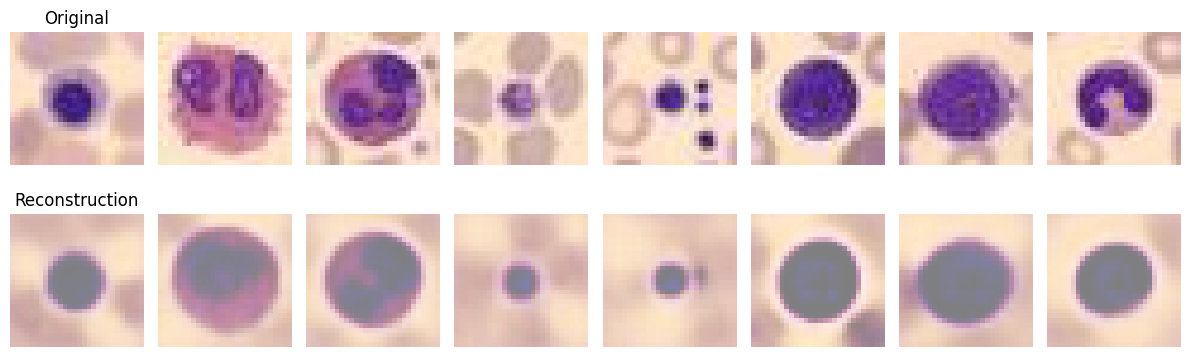

In [13]:
model.eval()
with torch.no_grad():
    recon_batch, _, _ = model(data)

fig, axes = plt.subplots(2, 8, figsize=(12, 4)) # 2 rows, 8 columns

# Convert to numpy for plotting
imgs = data.cpu().numpy()
recons = recon_batch.cpu().numpy()

for i in range(8):
    # Original (Top Row)
    # Un-normalize: (x * 0.5) + 0.5 to map back to [0,1]
    orig_img = np.transpose(imgs[i], (1, 2, 0)) * 0.5 + 0.5
    axes[0, i].imshow(orig_img.clip(0, 1))
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Original")

    # Reconstructed (Bottom Row)
    recon_img = np.transpose(recons[i], (1, 2, 0)) * 0.5 + 0.5
    axes[1, i].imshow(recon_img.clip(0, 1))
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Reconstruction")

plt.tight_layout()
plt.savefig("../results.png", dpi=150)
print("✅ Saved visualization to 'results.png'. Check your notebook folder!")